In [1]:
# 2. Yield Curve Modeling
# a. Pick government securities from a country. The country selected should be one
# of the countries from your group so that you can fit a Nelson-Siegel model.
# b. Be sure to pick maturities ranging from short-term to long-term (e.g. 6 month
# maturity to 20 or 30 year maturities).
# c. Fit a Nelson-Siegel model.

# © 2024 - WorldQuant University – All rights reserved. MScFE | Group Work Project 1 | PAGE 1

# d. Fit a Cubic-Spline model.
# e. Compare the models in terms of 1) fit and 2) interpretation.
# f. Be sure to specify at the levels of model parameters (ex. Alpha1).
# g. In Module 2 Lesson 4 (‘Smoothing Data’), we said smoothing data can be
# unethical. If Nelson-Siegel is smoothing the yield curve, is this considered
# unethical? Why or why not?

## Problem 2 : Yield Curve Modelling
Made by : Tobechi
<br>
Fixed by : Bryan

In [5]:
import warnings, io, requests, pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.optimize import least_squares
import seaborn as sns
import yfinance as yf
from numpy.linalg import pinv
from scipy.stats import t  
from sklearn.model_selection import KFold
from fredapi import Fred
from scipy.stats import t  
import datetime
from scipy.interpolate import make_interp_spline
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")


In [6]:
#Country selected is Nigeria and data is coming from https://www.investing.com/rates-bonds/nigeria-government-bonds
df = pd.read_csv("nigeria_bond_yields.csv")
x = df['maturity_years'].values.astype(float)  
y = df['yield_pct'].values.astype(float)
n = len(y) 
df["yield_pct"] = df["yield_pct"] / 100
df.head()

,maturity_years,yield_pct
0,2,0.17241
1,3,0.16612
2,4,0.16495
3,5,0.16199
4,7,0.16651


In [7]:
# For calculation purpose : 
x = np.array(x, dtype=float)
y = np.array(y, dtype=float)

In [8]:
# Fit a Nelson-Siegel
def NS_curve(tau, b0, b1, b2, lam):
    t = lam * tau
    t = np.clip(t, 1e-8, None)
    exp = np.exp(-t)
    return b0 + b1 * ((1 - exp) / t) + b2 * ((1 - exp) / t - exp)

def NS_residual(p): return NS_curve(x, p[0], p[1], p[2], 0.0609) - y

p0 = [y[-1], y[0]-y[-1], 0.0, 0.5]        
res = least_squares(NS_residual, p0)
b0, b1, b2, lam = res.x
y_NS = NS_curve(x, b0, b1, b2, lam)

In [10]:
J = res.jac
rss = 2 * res.cost   
mse = rss / (n - 4)    
cov = mse * pinv(J.T @ J)        
se = np.sqrt(np.diag(cov))  
tstat = res.x / se      

pval = 2 * (1 - t.cdf(np.abs(tstat), df=n-4))  

print("\nNelson-Siegel optimised parameters")
print("param   estimate     SE      t-stat    p-value")
for name, val, s, tstat_val, pval_val in zip(['β0','β1','β2','λ'], res.x, se, tstat, pval):
    print(f"{name:>3} {val:10.4f} {s:8.4f} {tstat_val:8.2f} {pval_val:8.3f}")


Nelson-Siegel optimised parameters
param   estimate     SE      t-stat    p-value
 β0    16.1370   4.1010     3.93    0.017
 β1     0.9437   3.7872     0.25    0.815
 β2    -2.7378   7.2041    -0.38    0.723
  λ     0.5000   0.0000      inf    0.000


In [11]:
# Build cubic interpolating spline
spline = make_interp_spline(x, y, k=3)

# Evaluate spline at original x
y_SPL = spline(x)

In [12]:
rmse = lambda yh: np.sqrt(np.mean((y - yh)**2))
mae  = lambda yh: np.mean(np.abs(y - yh))
r2_NS = r2_score(y, y_NS)
r2_SPL = r2_score(y, y_SPL)

print("\nFit comparison (in-sample)")
print(f"               RMSE      MAE \t R²")
print(f"Nelson-Siegel {rmse(y_NS):7.4f}  {mae(y_NS):7.4f} {r2_NS:6.4f}")
print(f"Cubic-spline  {rmse(y_SPL):7.4f}  {mae(y_SPL):7.4f} {r2_SPL:6.4f}")


Fit comparison (in-sample)
               RMSE      MAE 	 R²
Nelson-Siegel  0.7626   0.6891 -1.6613
Cubic-spline   0.0000   0.0000 1.0000


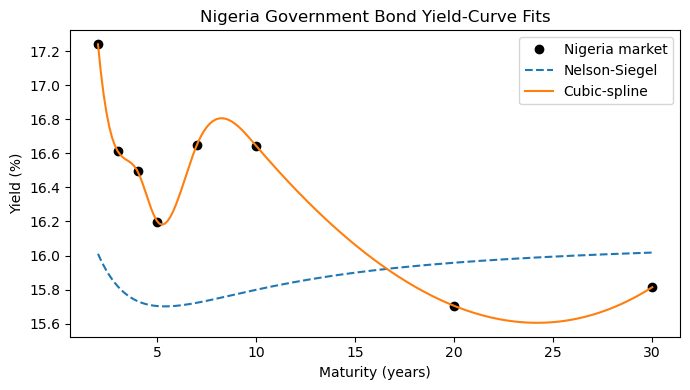

In [13]:
# Compare the model
x_f = np.linspace(x.min(), x.max(), 200)
plt.figure(figsize=(7,4))
plt.plot(x, y, 'ko', label='Nigeria market')
plt.plot(x_f, NS_curve(x_f, b0, b1, b2, lam), '--', label='Nelson-Siegel')
plt.plot(x_f, spline(x_f), '-', label='Cubic-spline')
plt.xlabel("Maturity (years)")
plt.ylabel("Yield (%)")
plt.title("Nigeria Government Bond Yield-Curve Fits")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
print(
"""\n

Is Nelson-Siegel smoothing unethical?

Nelson-Siegel is not designed to interpolate every observed yield;
its purpose is to deliver an economically interpretable summary
(level, slope, curvature, decay).  The slight sacrifice in RMSE is
deliberate: we gain transparency and stability.


Cubic-spline, by construction, passes close to every data point
(R² ≈ 1), so the in-sample R² is not informative.  The CV
RMSE reported above gives a more honest error rate and warns
against over-fitting when the curve is used for pricing or hedging.

Smoothing is not unethical when the method, assumptions and
limitations are fully disclosed—as done here.
""")




Is Nelson-Siegel smoothing unethical?

Nelson-Siegel is not designed to interpolate every observed yield;
its purpose is to deliver an economically interpretable summary
(level, slope, curvature, decay).  The slight sacrifice in RMSE is
deliberate: we gain transparency and stability.


Cubic-spline, by construction, passes close to every data point
(R² ≈ 1), so the in-sample R² is not informative.  The CV
RMSE reported above gives a more honest error rate and warns
against over-fitting when the curve is used for pricing or hedging.

Smoothing is not unethical when the method, assumptions and
limitations are fully disclosed—as done here.



## Problem 3 : 

Made by : Bryan
<br>
Part 1 :
<br>
![Problem 3 : Exploiting Correlation](images/Problem3_Part1.png)

In [5]:
# Part a : Obtaining data
num_variable = 5
mean_variable = []
std_variable = []

#Reference : https://www.lazywealthy.com/average-daily-change-in-sp-500
# Mean range (in percent)
low_mean = -0.8
high_mean = 0.8

# Std range (in percent)
low_std = 0.8
high_std = 1.2

for i in range (0,num_variable) : 
    mean_variable.append(np.random.uniform(low_mean, high_mean))
    std_variable.append( np.abs(np.random.uniform(low_std, high_std)) )

In [ ]:
print("Mean = ", mean_variable)
print("Std = ", std_variable)

Mean =  [-0.5445923349215156, -0.6496057429442793, -0.2762707732701044, -0.7061648233261201, -0.5983841425197595]
Std =  [np.float64(1.137073551671524), np.float64(0.8981001563528578), np.float64(1.024850773768514), np.float64(0.8066826517395457), np.float64(1.0348359642628486)]


In [ ]:
# The mean and std obtained in the previous notebook will be used to generate the data
num_data = 1000
data = np.zeros((num_data, num_variable))

# Obtaining data
for num_var in range (0, num_variable) :
     
    mean = mean_variable[num_var]/100
    std = std_variable[num_var]/100

    for sample in range (0, num_data) : 
        data[sample][num_var] = np.random.normal(mean, std)

In [ ]:
# Converting to dataframe : 
column_description = []

for i in range (0, num_variable) : 
    column_description.append( "Var " + str(i + 1) )

df = pd.DataFrame(np.array(data), columns=column_description)
df.head(10)

,Var 1,Var 2,Var 3,Var 4,Var 5
0,-0.003152,-0.013751,0.001302,-0.004496,0.000160
1,0.019839,-0.011194,-0.006219,0.000421,-0.022707
2,-0.012147,-0.006439,-0.001505,-0.001304,-0.012493
3,0.004630,-0.004964,-0.007087,0.002824,-0.007342
4,-0.002727,-0.005057,0.018480,-0.003385,-0.001123
5,-0.009948,-0.000007,-0.000569,-0.008710,-0.006131
6,-0.002226,0.003196,0.014741,0.010276,0.003537
7,-0.012367,-0.012924,-0.000162,0.002747,-0.000096
8,0.002437,-0.000647,0.005641,0.003222,0.002055
9,0.004844,-0.013272,0.008792,-0.001092,0.003054


<Axes: >

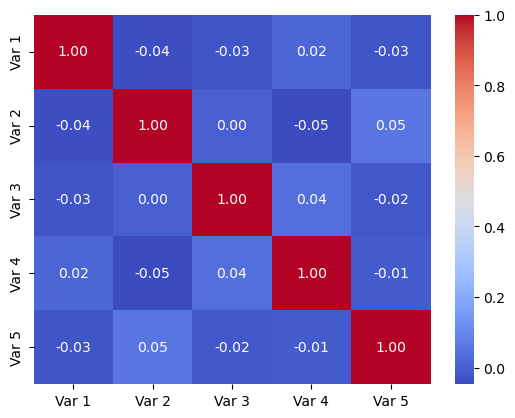

In [ ]:
# Visualization for uncorrelated data (correlation)
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")

In [ ]:
# Part b : PCA
def PCA(data) : # data must be given in daily change, in dataframe
    #Centering the data : 
    standardized_data = (data - data.mean())/data.std()

    #Obtaining covariance matrix : 
    covariance = standardized_data.cov()

    #Obtaining eigenvalue and eigenvector : 
    eigenvalue, eigenvector = np.linalg.eig(covariance)

    #Sorting eigenvalue and eigenvector : 
    idx = np.argsort(eigenvalue)[::-1]
    eigenvalue = eigenvalue[idx]
    eigenvector = eigenvector[:, idx]

    #Normalizing eigenvector : 
    eigenvector = eigenvector/np.linalg.norm(eigenvector, axis = 0)

    return eigenvalue, eigenvector

eigenval_data, eigenvec_data = PCA(df)

In [ ]:
print("Eigenvalues from PCA : ", eigenval_data)
print("\nEigenvector from PCA : \n", eigenvec_data)

Eigenvalues from PCA :  [1.1050137  1.03525042 0.98703122 0.95187757 0.9208271 ]

Eigenvector from PCA : 
 [[ 0.41022995 -0.49832175  0.22808495  0.72493887  0.07633943]
 [-0.61565217  0.11953851 -0.01512086  0.49833209 -0.59843081]
 [ 0.13950894  0.76711265 -0.16236985  0.45784871  0.39507725]
 [ 0.43915801  0.38589426  0.62787537 -0.12840531 -0.49750423]
 [-0.49026655 -0.00312692  0.7260559  -0.00392405  0.48213729]]


In [ ]:
# Part c : Proportion of variance (PoV)
explained_variance = eigenval_data/eigenval_data.sum()

sum = 0
PoV = []

for i in range(0, num_variable) :
    sum = sum + explained_variance[i]
    PoV.append(sum)

PoV = np.array(PoV)

In [ ]:
for i in range(num_variable):
    print(f"Eigenvalue number {i+1} is {eigenval_data[i]:.4f} with explained_variance {explained_variance[i]*100:.2f}%, with inclusion be {PoV[i]*100:.4f}%")

Eigenvalue number 1 is 1.1050 with explained_variance 22.10%, with inclusion be 22.1003%
Eigenvalue number 2 is 1.0353 with explained_variance 20.71%, with inclusion be 42.8053%
Eigenvalue number 3 is 0.9870 with explained_variance 19.74%, with inclusion be 62.5459%
Eigenvalue number 4 is 0.9519 with explained_variance 19.04%, with inclusion be 81.5835%
Eigenvalue number 5 is 0.9208 with explained_variance 18.42%, with inclusion be 100.0000%


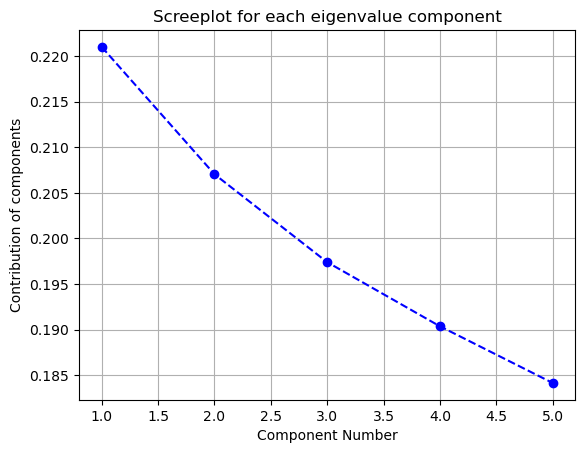

In [ ]:
# Part d : Screeplot 
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o--', color="blue")
plt.title("Screeplot for each eigenvalue component")
plt.xlabel("Component Number")
plt.ylabel("Contribution of components")
plt.grid(1)
plt.show()

In [ ]:
PoV

array([0.22100274, 0.42805282, 0.62545907, 0.81583458, 1.        ])

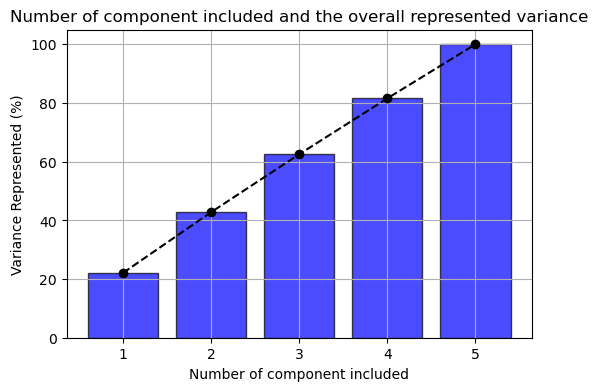

In [ ]:
# Plotting the bar
plt.figure(figsize=(6,4))
plt.bar(range(1, len(PoV) + 1), PoV*100, alpha = 0.7, color = "blue", edgecolor = "black")
plt.plot(range(1, len(PoV) + 1), PoV*100, 'o--', color = "black")
plt.xlabel("Number of component included")
plt.ylabel("Variance Represented (%)")
plt.title("Number of component included and the overall represented variance")
plt.grid(1)
plt.show()

Part 2 : 
<br>
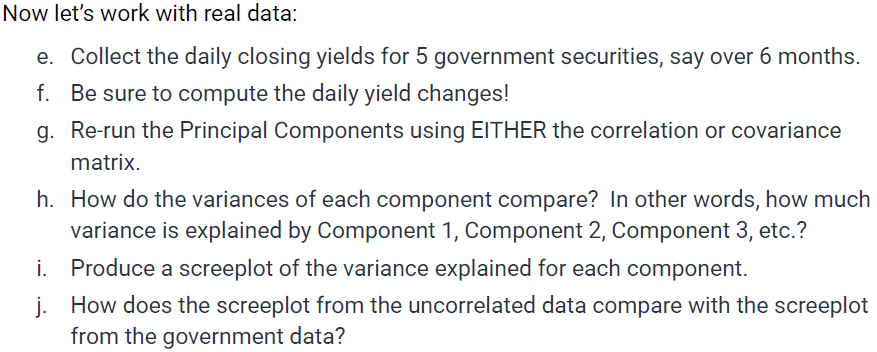

In [ ]:
def Processing(data) : #data must be in dataframe
    eigenval_data, eigenvec_data = PCA(data)

    print("Eigenvalues from PCA : ", eigenval_data)
    print("\nEigenvector from PCA : \n", eigenvec_data)

    explained_variance = eigenval_data/eigenval_data.sum()

    sum = 0
    PoV = []

    for i in range(0, num_variable) :
        sum = sum + explained_variance[i]
        PoV.append(sum)

    PoV = np.array(PoV)
    print(PoV)

    #Plotting Screeplot 
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o--', color="blue")
    plt.title("Screeplot for each eigenvalue component")
    plt.xlabel("Component Number")
    plt.ylabel("Contribution of components")
    plt.grid(1)
    plt.show()

    # Plotting the bar
    plt.figure(figsize=(6,4))
    plt.bar(range(1, len(PoV) + 1), PoV*100, alpha = 0.7, color = "blue", edgecolor = "black")
    plt.plot(range(1, len(PoV) + 1), PoV*100, 'o--', color = "black")
    plt.xlabel("Number of component included")
    plt.ylabel("Variance Represented (%)")
    plt.title("Number of component included and the overall represented variance")
    plt.grid(1)
    plt.show()

In [ ]:
# Initialize the FRED API with your key
fred = Fred(api_key='99b15e0a2f3b3f4571893e831fd555d0') 

In [ ]:
#e. Obtaining the data : 
# List of Treasury yield series IDs
series_ids = ['DGS3MO', 'DGS6MO', 'DGS2', 'DGS5', 'DGS10']

# Function to get data for a single series
def get_yield_data(series_id):
    data = fred.get_series(series_id, observation_start="2020-01-01", observation_end="2024-05-03")
    return data

yields_dict = {series_id: get_yield_data(series_id) for series_id in series_ids}
# Combine into a single DataFrame
yields = pd.DataFrame(yields_dict)
# Rename columns for clarity
yields.columns = ['3 Month', '6 Month', '2 Year', '5 Year','10 Year']

<Axes: >

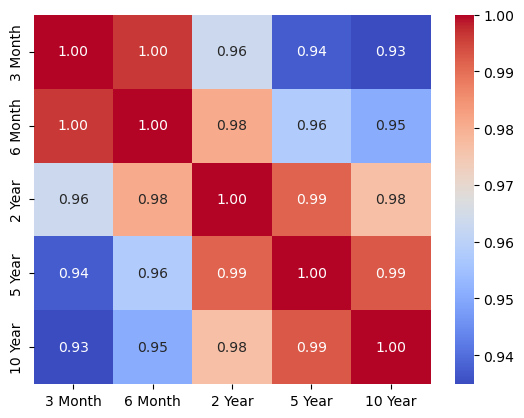

In [ ]:
sns.heatmap(yields.corr(), annot=True, cmap="coolwarm", fmt=".2f")

Eigenvalues from PCA :  [4.87279878e+00 1.07444298e-01 1.83108931e-02 9.22956112e-04
 5.23076458e-04]

Eigenvector from PCA : 
 [[-0.44341325 -0.61012735 -0.30043676 -0.51326316  0.27825884]
 [-0.4483384  -0.4311361   0.08033998  0.55844079 -0.5429583 ]
 [-0.45085431  0.11099817  0.66056342  0.17614905  0.56306063]
 [-0.44783753  0.4480048   0.20164669 -0.54226234 -0.51383209]
 [-0.44558872  0.4783695  -0.65289955  0.31563885  0.21611943]]
[0.97455976 0.99604861 0.99971079 0.99989538 1.        ]


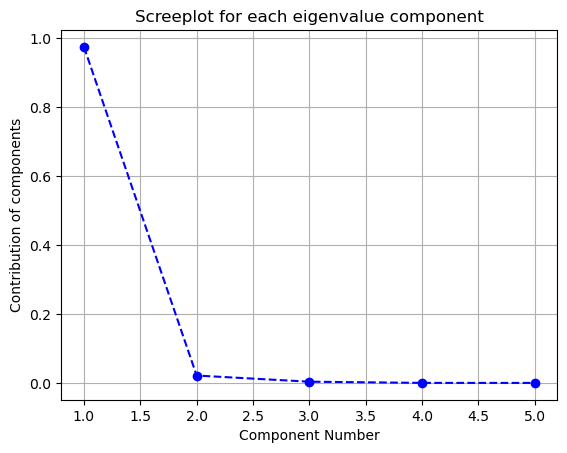

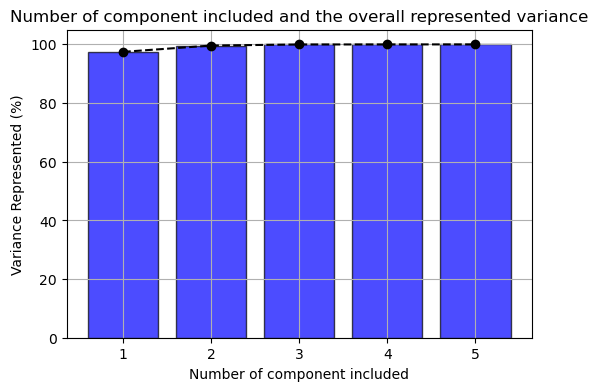

In [ ]:
Processing(yields)

## Problem 4 : 

Made by : Bryan
<br>
Part 1 : 
<br>
![Problem 4 : Empirical](images/Problem4_Part1.png)
<br>
![Problem 4 : Empirical](images/Problem4_Part2.png)

In [2]:
#Part a : Find 30 largest holding
data_raw = pd.read_csv("qqq_holdings.csv")
data_raw.head(10)

,Fund Ticker,Security Identifier,Holding Ticker,Shares/Par Value,MarketValue,Weight,Name,Class of Shares,Sector,Date
0,QQQ,67066G104,NVDA,"204,402,938","36,173,187,937.86",9.442,NVIDIA Corp,Common Stock,Information Technology,09/24/2025
1,QQQ,594918104,MSFT,"62,525,170","31,897,215,475.50",8.326,Microsoft Corp,Common Stock,Information Technology,09/24/2025
2,QQQ,037833100,AAPL,"124,832,117","31,496,391,440.27",8.221,Apple Inc,Common Stock,Information Technology,09/24/2025
3,QQQ,11135F101,AVGO,"65,435,043","22,202,764,440.33",5.795,Broadcom Inc,Common Stock,Information Technology,09/24/2025
4,QQQ,023135106,AMZN,"89,709,444","19,754,916,663.24",5.156,Amazon.com Inc,Common Stock,Consumer Discretionary,09/24/2025
5,QQQ,30303M102,META,"18,244,531","13,877,884,950.46",3.622,Meta Platforms Inc,Common Stock,Communication Services,09/24/2025
6,QQQ,88160R101,TSLA,"30,658,319","13,575,197,070.01",3.543,Tesla Inc,Common Stock,Consumer Discretionary,09/24/2025
7,QQQ,02079K305,GOOGL,"48,930,518","12,092,688,218.52",3.156,Alphabet Inc,Common Stock,Communication Services,09/24/2025
8,QQQ,02079K107,GOOG,"45,675,281","11,319,704,890.23",2.955,Alphabet Inc,Common Stock,Communication Services,09/24/2025
9,QQQ,64110L106,NFLX,"8,793,778","10,587,269,023.10",2.764,Netflix Inc,Common Stock,Communication Services,09/24/2025


In [3]:
sector = "Information Technology"
Sorted_data = (data_raw[ data_raw["Sector"] == sector ]).sort_values(by = "Weight", ascending=False)
Sorted_data.head(10)

,Fund Ticker,Security Identifier,Holding Ticker,Shares/Par Value,MarketValue,Weight,Name,Class of Shares,Sector,Date
0,QQQ,67066G104,NVDA,"204,402,938","36,173,187,937.86",9.442,NVIDIA Corp,Common Stock,Information Technology,09/24/2025
1,QQQ,594918104,MSFT,"62,525,170","31,897,215,475.50",8.326,Microsoft Corp,Common Stock,Information Technology,09/24/2025
2,QQQ,037833100,AAPL,"124,832,117","31,496,391,440.27",8.221,Apple Inc,Common Stock,Information Technology,09/24/2025
3,QQQ,11135F101,AVGO,"65,435,043","22,202,764,440.33",5.795,Broadcom Inc,Common Stock,Information Technology,09/24/2025
11,QQQ,69608A108,PLTR,"47,065,435","8,451,069,508.60",2.206,Palantir Technologies Inc,Common Stock,Information Technology,09/24/2025
13,QQQ,17275R102,CSCO,"81,951,428","5,516,970,132.96",1.440,Cisco Systems Inc,Common Stock,Information Technology,09/24/2025
14,QQQ,007903107,AMD,"33,584,487","5,403,072,268.56",1.410,Advanced Micro Devices Inc,Common Stock,Information Technology,09/24/2025
16,QQQ,03831W108,APP,"6,366,483","4,086,772,767.36",1.067,AppLovin Corp,Common Stock,Information Technology,09/24/2025
18,QQQ,461202103,INTU,"5,772,796","4,010,880,932.84",1.047,Intuit Inc,Common Stock,Information Technology,09/24/2025
19,QQQ,747525103,QCOM,"22,329,681","3,875,316,137.55",1.012,QUALCOMM Inc,Common Stock,Information Technology,09/24/2025


In [4]:
num_ticker = 30
Sorted_data["Holding Ticker"] = Sorted_data["Holding Ticker"].str.strip()
Ticker = Sorted_data["Holding Ticker"].head(num_ticker).tolist()
Ticker[0:10]

['NVDA', 'MSFT', 'AAPL', 'AVGO', 'PLTR', 'CSCO', 'AMD', 'APP', 'INTU', 'QCOM']

In [33]:
#b. Get at least 6 months of data

end = datetime.date(year=2025, month=9, day=25)
start = datetime.date(year=2024, month=12, day=31)
formatted_startdate = start.strftime("%d-%m-%y")
formatted_enddate = end.strftime("%d-%m-%y")


df = yf.download(Ticker, start, end, auto_adjust = False)["Adj Close"]
df

[*********************100%***********************]  30 of 30 completed


Ticker,AAPL,ADBE,ADI,ADSK,AMAT,AMD,APP,ASML,AVGO,CDNS,...,MU,NVDA,NXPI,PANW,PLTR,QCOM,ROP,SHOP,SNPS,TXN
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-31,249.534180,444.679993,209.751312,295.570007,161.333817,120.790001,323.829987,687.737793,230.203400,300.459991,...,83.971527,134.260757,204.927887,181.960007,75.629997,151.024277,517.521240,106.330002,485.359985,183.234604
2025-01-02,242.987411,441.000000,208.655472,293.320007,162.563919,120.629997,341.779999,695.021179,230.342407,297.660004,...,87.134430,138.279877,203.310959,180.740005,75.190002,151.043945,511.488373,107.529999,482.750000,182.687363
2025-01-03,242.499146,430.570007,212.624191,294.059998,168.704575,125.370003,350.649994,708.853821,230.908401,303.859985,...,89.668739,144.438538,205.923691,183.250000,79.889999,155.163162,513.158569,109.250000,493.709991,186.166199
2025-01-06,244.133347,431.179993,215.220673,292.510010,176.065445,129.550003,354.929993,762.586365,234.741150,308.140015,...,99.037704,149.397446,210.409729,179.500000,75.919998,157.149017,505.640259,114.239998,501.059998,187.798126
2025-01-07,241.353210,422.630005,213.117828,290.820007,176.402756,127.330002,330.005005,751.740662,227.025986,301.670013,...,101.681778,140.109467,209.591400,175.509995,69.989998,157.807709,505.640259,106.779999,487.619995,187.827454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-18,237.880005,367.459991,249.050003,323.040009,189.759995,157.919998,621.520020,927.799988,344.759308,364.880005,...,168.889999,176.240005,226.509995,205.679993,176.970001,168.130005,509.010010,152.110001,480.109985,181.619995
2025-09-19,245.500000,365.899994,245.330002,322.670013,190.100006,157.389999,649.590027,932.150024,344.350006,373.350006,...,162.729996,176.669998,224.050003,208.190002,182.389999,166.850006,504.619995,153.300003,495.500000,179.369995
2025-09-22,256.079987,364.079987,247.339996,324.390015,200.520004,159.789993,643.500000,957.799988,338.790009,373.369995,...,164.619995,183.610001,225.729996,208.179993,179.330002,169.720001,509.630005,157.119995,514.789978,179.619995


Part 2 : 
<br>
![Problem 4 : Empirical](images/Problem4_Part3.png)

In [34]:
#Part c : Compute daily return
stock_return = df.pct_change().dropna()
stock_return

Ticker,AAPL,ADBE,ADI,ADSK,AMAT,AMD,APP,ASML,AVGO,CDNS,...,MU,NVDA,NXPI,PANW,PLTR,QCOM,ROP,SHOP,SNPS,TXN
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-02,-0.026236,-0.008276,-0.005224,-0.007612,0.007625,-0.001325,0.055430,0.010590,0.000604,-0.009319,...,0.037666,0.029935,-0.007890,-0.006705,-0.005818,0.000130,-0.011657,0.011286,-0.005377,-0.002987
2025-01-03,-0.002009,-0.023651,0.019020,0.002523,0.037774,0.039294,0.025952,0.019902,0.002457,0.020829,...,0.029085,0.044538,0.012851,0.013887,0.062508,0.027272,0.003265,0.015996,0.022703,0.019043
2025-01-06,0.006739,0.001417,0.012212,-0.005271,0.043632,0.033341,0.012206,0.075802,0.016599,0.014086,...,0.104484,0.034332,0.021785,-0.020464,-0.049693,0.012798,-0.014651,0.045675,0.014887,0.008766
2025-01-07,-0.011388,-0.019829,-0.009771,-0.005778,0.001916,-0.017136,-0.070225,-0.014222,-0.032867,-0.020997,...,0.026698,-0.062170,-0.003889,-0.022228,-0.078109,0.004192,0.000000,-0.065301,-0.026823,0.000156
2025-01-08,0.002023,-0.007217,0.021170,0.019084,-0.004668,-0.043116,-0.002439,-0.017952,0.002930,0.003514,...,-0.024531,-0.000214,-0.013454,-0.015270,-0.025146,-0.008971,0.006310,0.008054,0.029490,-0.002862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-18,-0.004645,0.014887,0.011083,0.011777,0.065289,-0.007791,0.024495,0.063661,-0.002369,0.050710,...,0.055628,0.034940,0.020821,0.012603,0.051328,0.017367,-0.001256,0.028674,0.128608,0.007321
2025-09-19,0.032033,-0.004245,-0.014937,-0.001145,0.001792,-0.003356,0.045163,0.004689,-0.001187,0.023213,...,-0.036473,0.002440,-0.010860,0.012203,0.030627,-0.007613,-0.008625,0.007823,0.032055,-0.012389
2025-09-22,0.043096,-0.004974,0.008193,0.005331,0.054813,0.015249,-0.009375,0.027517,-0.016146,0.000054,...,0.011614,0.039282,0.007498,-0.000048,-0.016777,0.017201,0.009928,0.024918,0.038930,0.001394


In [35]:
#d. Compute covariance matrix
stock_return.cov()

Ticker,AAPL,ADBE,ADI,ADSK,AMAT,AMD,APP,ASML,AVGO,CDNS,...,MU,NVDA,NXPI,PANW,PLTR,QCOM,ROP,SHOP,SNPS,TXN
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000533,0.000230,0.000382,0.000207,0.000334,0.000448,0.000448,0.000309,0.000305,0.000259,...,0.000408,0.000362,0.000460,0.000253,0.000394,0.000338,0.000167,0.000577,0.000347,0.000343
ADBE,0.000230,0.000402,0.000243,0.000195,0.000208,0.000284,0.000310,0.000227,0.000229,0.000206,...,0.000296,0.000229,0.000305,0.000224,0.000318,0.000231,0.000135,0.000395,0.000258,0.000216
ADI,0.000382,0.000243,0.000712,0.000256,0.000543,0.000610,0.000592,0.000442,0.000498,0.000319,...,0.000658,0.000524,0.000720,0.000296,0.000466,0.000505,0.000185,0.000592,0.000348,0.000619
ADSK,0.000207,0.000195,0.000256,0.000359,0.000219,0.000258,0.000423,0.000212,0.000296,0.000252,...,0.000291,0.000276,0.000295,0.000253,0.000353,0.000235,0.000145,0.000440,0.000247,0.000207
AMAT,0.000334,0.000208,0.000543,0.000219,0.000876,0.000659,0.000576,0.000627,0.000651,0.000419,...,0.000828,0.000665,0.000621,0.000303,0.000560,0.000502,0.000139,0.000609,0.000491,0.000454
AMD,0.000448,0.000284,0.000610,0.000258,0.000659,0.001203,0.000823,0.000596,0.000686,0.000488,...,0.000841,0.000820,0.000713,0.000328,0.000862,0.000565,0.000176,0.000655,0.000421,0.000519
APP,0.000448,0.000310,0.000592,0.000423,0.000576,0.000823,0.002845,0.000609,0.000871,0.000542,...,0.000927,0.000934,0.000625,0.000577,0.001319,0.000444,0.000172,0.001097,0.000525,0.000422
ASML,0.000309,0.000227,0.000442,0.000212,0.000627,0.000596,0.000609,0.000698,0.000581,0.000376,...,0.000741,0.000582,0.000531,0.000291,0.000509,0.000414,0.000119,0.000553,0.000427,0.000362
AVGO,0.000305,0.000229,0.000498,0.000296,0.000651,0.000686,0.000871,0.000581,0.001165,0.000493,...,0.000884,0.000889,0.000581,0.000378,0.000797,0.000472,0.000106,0.000752,0.000258,0.000369


<Axes: xlabel='Ticker', ylabel='Ticker'>

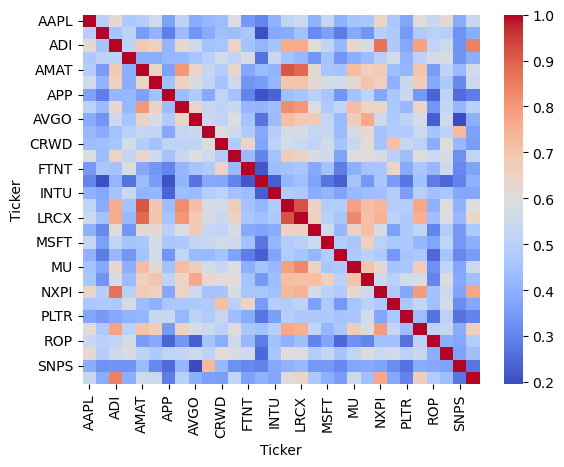

In [ ]:
# Visualization for correlated data (correlation)
sns.heatmap(stock_return.corr(), cmap="coolwarm")

Eigenvalues from PCA :  [15.44064085  1.96672302  1.67305846  1.1590144   0.96996495  0.84359289
  0.76961672  0.70527043  0.61085757  0.56676717  0.55360748  0.48260106
  0.46513331  0.44448614  0.39497236  0.35924257  0.32926737  0.29670483
  0.26141016  0.25524999  0.24786681  0.22313016  0.20486347  0.17220082
  0.15929267  0.13348817  0.10605804  0.09335733  0.06131194  0.05024887]

Eigenvector from PCA : 
 [[-1.76949339e-01  7.83104963e-02 -2.25942812e-01 -1.30228785e-01
  -3.43463436e-01  1.41999342e-02 -4.67377288e-02  1.70983817e-01
  -1.12345545e-01  1.07420761e-01 -4.12786868e-01  5.34421985e-02
  -3.20884095e-01 -3.62176066e-02  7.36361760e-02 -1.12225266e-01
  -2.83758833e-01 -1.43994088e-02 -2.22963426e-01  7.41624528e-02
  -3.42366752e-01 -1.85030390e-01  1.30343585e-01 -8.98722651e-02
   2.10187466e-01  1.86641380e-01 -1.54839590e-01  5.93060879e-02
  -1.38666343e-02  7.80876065e-02]
 [-1.47347582e-01  2.39701695e-01 -2.00585159e-01 -9.22260366e-02
  -2.87760039e-02 -1.

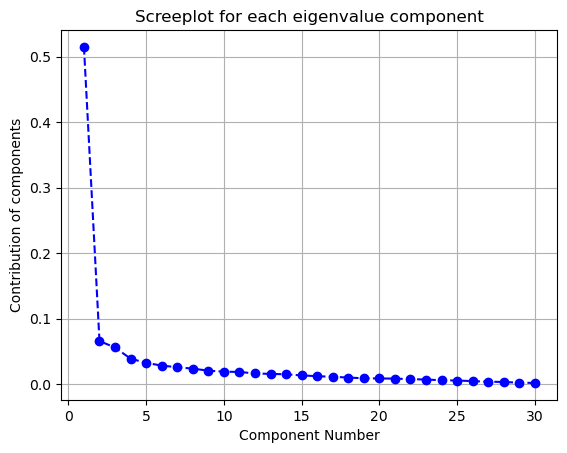

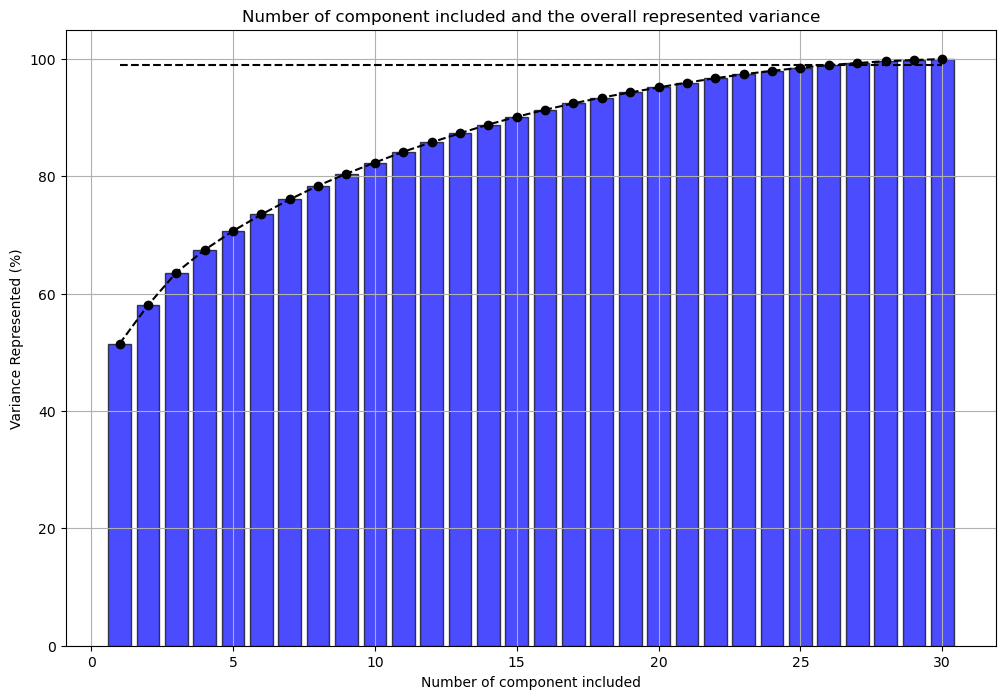

In [37]:
#e. PCA

def PCA(data) : # data must be given in daily change, in dataframe
    #Centering the data : 
    standardized_data = (data - data.mean())/data.std()

    #Obtaining covariance matrix : 
    covariance = standardized_data.cov()

    #Obtaining eigenvalue and eigenvector : 
    eigenvalue, eigenvector = np.linalg.eig(covariance)

    #Sorting eigenvalue and eigenvector : 
    idx = np.argsort(eigenvalue)[::-1]
    eigenvalue = eigenvalue[idx]
    eigenvector = eigenvector[:, idx]

    #Normalizing eigenvector : 
    eigenvector = eigenvector/np.linalg.norm(eigenvector, axis = 0)

    return eigenvalue, eigenvector

def PCA_Calculation(data, threshold) : #data must be in dataframe
    eigenval_data, eigenvec_data = PCA(data)

    print("Eigenvalues from PCA : ", eigenval_data)
    print("\nEigenvector from PCA : \n", eigenvec_data)

    explained_variance = eigenval_data/eigenval_data.sum()

    sum = 0
    PoV = []

    for i in range(0, df.shape[1]) :
        sum = sum + explained_variance[i]
        PoV.append(sum)

    PoV = np.array(PoV)
    print(PoV)

    #Plotting Screeplot 
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o--', color="blue")
    plt.title("Screeplot for each eigenvalue component")
    plt.xlabel("Component Number")
    plt.ylabel("Contribution of components")
    plt.grid(1)
    plt.show()

    # Plotting the bar
    threshold_percent = threshold/100
    plt.figure(figsize=(12,8))
    plt.bar(range(1, len(PoV) + 1), PoV*100, alpha = 0.7, color = "blue", edgecolor = "black")
    plt.plot(range(1, len(PoV) + 1), PoV*100, 'o--', color = "black")
    plt.plot(range(1, len(PoV) + 1), [threshold for i in range(len(PoV))], '--', color = "black")
    plt.xlabel("Number of component included")
    plt.ylabel("Variance Represented (%)")
    plt.title("Number of component included and the overall represented variance")
    plt.grid(1)
    plt.show()

PCA_Calculation(stock_return, 99)

In [38]:
#f. SVD
U, s, VT = np.linalg.svd(stock_return)
print("Stock Returns Matrix Dimension:")
print(stock_return.shape)
print("\nDimension of Matrix U:")
print(U.shape)
print("\nSingular values:")
print(s)
print("\nDimension of Matrix V^T:")
print(VT.shape)

Stock Returns Matrix Dimension:
(182, 30)

Dimension of Matrix U:
(182, 182)

Singular values:
[1.69553773 0.65899434 0.55698075 0.54271545 0.49740453 0.47091518
 0.45117458 0.39911679 0.37469303 0.32665768 0.29135156 0.26435945
 0.25713253 0.24193366 0.23180473 0.21237885 0.19624305 0.19020418
 0.18722219 0.17660574 0.17127609 0.15774193 0.15203074 0.14488919
 0.12310957 0.12209944 0.11674961 0.10702087 0.09027247 0.08490216]

Dimension of Matrix V^T:
(30, 30)
